<a href="https://colab.research.google.com/github/TiagoIesbick/dashboard-etl/blob/main/previsoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import pathlib
import re
import logging
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [20]:
# Set Prophet loggers to WARNING level
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [21]:
# filling empty cells after the first filled cell in a column with 0
def fill_zero(df: pd.DataFrame) -> pd.DataFrame:
    for column in df.columns[1:]:
        first_valid = df[column].first_valid_index()
        if first_valid is not None:
            df.loc[first_valid:, column] = df.loc[first_valid:, column].fillna(0)
    return df

# creating moving average dataframes
def moving_averages(df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_ma = df.copy()
    df_ma.iloc[:, 1:-1] = df_ma.iloc[:, 1:-1].rolling(window).mean()
    df_ma.dropna(axis=1, how='all', inplace=True)
    return df_ma

# def str_to_float(value: str) -> float:
#   value = str(value).replace('.', '').replace(',', '.')
#   value = re.sub(r'[A-Za-z]|\s', '', value)
#   return float(0) if value == '' else float(value)

# def agrupamento_format(value: str) -> str:
#   if re.search(r'^0{2}', value[:2]):
#     value = '   ' + value
#   elif re.search(r'^[1-9]\d', value[:2]):
#     value = '      ' + value
#   return value

# dict_month = {'Janeiro': '01', 'Fevereiro': '02', 'Março': '03', 'Abril': '04',
#               'Maio': '05', 'Junho': '06', 'Julho': '07', 'Agosto': '08',
#               'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'}

In [22]:
# getting expense data

df_exp = pd.read_csv(r'/content/drive/MyDrive/Dashboard_data/final_data/df_exp.csv', sep=';', parse_dates=['Comp.pagto.'])
df_exp.loc[
    (df_exp['Proj/Ativ'] == 2529) &
    (df_exp['Rubrica'] == 339036040000),
    ['Unid. Orçam.', 'Proj/Ativ', 'Elemento', 'Rubrica', 'Vinc. Orçam.']
    ] = 7003, 9075, 339039, 339039030000, 6050
df_exp.drop('Rubrica', axis=1, inplace=True)

In [23]:
# Selecting and clearing data from 7001

df_7001 = df_exp.loc[
    (df_exp['Unid. Orçam.'] == 7001) &
    (df_exp['Vinc. Orçam.'].isin([400, 1, 6069])) &
    (df_exp['Comp.pagto.'].dt.year > 2011) &
    (~df_exp['Proj/Ativ'].isin([9042]))
].copy()

df_7001['Comp.pagto.'] = df_7001['Comp.pagto.'].dt.to_period('M')
df_7001.loc[df_7001['Proj/Ativ'] == 2870, 'Proj/Ativ'] = 4396
df_7001.loc[df_7001['Proj/Ativ'].isin([2872, 1507]), ['Proj/Ativ', 'Elemento']] = 4471, 339040
df_7001.loc[df_7001['Proj/Ativ'].isin([2873, 2532]), 'Proj/Ativ'] = 4413
df_7001.loc[df_7001['Proj/Ativ'].isin([1505, 1503, 1373, 1506]), 'Proj/Ativ'] = 2529
df_7001.loc[(df_7001['Proj/Ativ'] == 2681) & (df_7001['Elemento'] == 319192), 'Elemento'] = 319113
df_7001.loc[(df_7001['Proj/Ativ'] == 2529) & (df_7001['Elemento'] == 449092), 'Elemento'] = 449051
df_7001.loc[(df_7001['Proj/Ativ'] == 9071) & (df_7001['Elemento'] == 319091), 'Elemento'] = 339091
df_7001.loc[(df_7001['Proj/Ativ'] == 9071) & (df_7001['Elemento'].isin([339092, 339147])), 'Elemento'] = 339047
df_7001.loc[~((df_7001['Proj/Ativ'] == 9071) & (df_7001['Vinc. Orçam.'] == 1)), 'Vinc. Orçam.'] = 6069
df_7001.loc[(df_7001['Proj/Ativ'] == 2529) & (df_7001['Elemento'].isin([319011, 319016, 319092, 319094, 339036, 339046, 339049])), 'Proj/Ativ'] = 4396
df_7001.loc[(df_7001['Proj/Ativ'] == 2529) & (df_7001['Elemento'] == 319013), 'Proj/Ativ'] = 2680
df_7001['col'] = df_7001['Unid. Orçam.'].astype(str) + '-' + df_7001['Proj/Ativ'].astype(str) + '-' + df_7001['Elemento'].astype(str) + '-' + df_7001['Vinc. Orçam.'].astype(str)
df_7001 = df_7001[['Comp.pagto.', 'col', 'Result. pago']].groupby(['Comp.pagto.', 'col'], as_index=False).sum()
df_7001 = df_7001.pivot(index='Comp.pagto.', columns='col', values='Result. pago')
df_7001 = df_7001.iloc[:-1]
df_7001['Total'] = df_7001.sum(axis=1)
df_7001['T'] = np.arange(1, len(df_7001)+1)
df_7001.reset_index(inplace=True)
df_7001 = fill_zero(df_7001)

In [24]:
# prediction interval
start = df_7001.iloc[-1]['Comp.pagto.']
target = pd.Period(f'{start.year + 4}-12', freq='M')
month_diff = (target - start).n
last_T = df_7001.iloc[-1]['T']

current_year = df_7001.iloc[-1]['Comp.pagto.'].year
X_prev = {'T': [last_T + val for val in range(1, month_diff + 1)]}
X_prev = pd.DataFrame(X_prev)

years = [val for val in range(current_year, current_year+5)]

months = [start.to_timestamp() + pd.DateOffset(months=i) for i in range(1, month_diff + 1)]

In [25]:
def run_models(df: pd.DataFrame, years: list[int], X_prev: pd.DataFrame, is_ma: bool = False) -> pd.DataFrame:
  df_models = pd.DataFrame(columns=(['Modelo', 'R²', 'RMSE', 'MAE'] + years))

  def run_linear_models(X: np.ndarray | pd.DataFrame, y: np.ndarray | pd.Series, aux_df: pd.DataFrame, model: str, column: str) -> pd.DataFrame:
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    forecast = lr_model.predict(X)
    r2 = r2_score(y, forecast)
    RMSE = np.sqrt(mean_squared_error(y, forecast))
    MAE = mean_absolute_error(y, forecast)

    if model == 'lin-lin':
      y_pred = lr_model.predict(X_prev.values)
    elif model == 'log-log':
      y_pred = np.exp(lr_model.predict(np.log(X_prev).values))
    elif model == 'lin-log':
      y_pred = np.exp(lr_model.predict(X_prev.values))
    elif model == 'log-lin':
      y_pred = lr_model.predict(np.log(X_prev).values)
    else:
      raise ValueError(f"Unknown model type: {model}")

    forecast_df = pd.DataFrame({'date': months, 'y_pred': y_pred})
    forecast_df['year'] = forecast_df['date'].dt.year
    forecast_df['month'] = forecast_df['date'].dt.month

    if is_ma:
      december_forecasts = forecast_df[forecast_df['month'] == 12]
      forecast_years = {year: val * 12 for year, val in zip(december_forecasts['year'], december_forecasts['y_pred'])}
      if start.year not in forecast_years and start.month == 12:
        forecast_years[start.year] = df.loc[df['Comp.pagto.'] == start, column].values[0] * 12
    else:
      forecast_years = forecast_df.groupby('year')['y_pred'].sum().to_dict()
      if start.month != 12:
        forecast_years[start.year] += df.loc[df['Comp.pagto.'].dt.year == start.year, column].sum()
      else:
        forecast_years[start.year] = df.loc[df['Comp.pagto.'].dt.year == start.year, column].sum()

    model_dict = {'Modelo': model, 'R²': r2, 'RMSE': -RMSE, 'MAE': -MAE}
    model_dict.update(forecast_years)
    aux_df = pd.concat([aux_df, pd.DataFrame(model_dict, index=[0])], ignore_index=True)
    return aux_df

  def run_prophet_model(aux_df: pd.DataFrame, column:str) -> pd.DataFrame:
    prophet_df = df[['Comp.pagto.', column]].rename(columns={
        'Comp.pagto.': 'ds',
        column: 'y'
    }).dropna()

    if len(prophet_df) < 2:
            return aux_df

    prophet_df['ds'] = prophet_df['ds'].dt.to_timestamp()
    model = Prophet(yearly_seasonality=True)
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=month_diff, freq='MS')
    forecast = model.predict(future)

    forecast_train = forecast[forecast['ds'].isin(prophet_df['ds'])]
    r2 = r2_score(prophet_df['y'], forecast_train['yhat'])
    RMSE = np.sqrt(mean_squared_error(prophet_df['y'], forecast_train['yhat']))
    MAE = mean_absolute_error(prophet_df['y'], forecast_train['yhat'])

    partial_actual_sum = prophet_df[prophet_df['ds'].dt.year == start.year]['y'].sum()

    forecast_future = forecast[forecast['ds'] > prophet_df['ds'].max()]

    if is_ma:
      december_forecasts = forecast_future[forecast_future['ds'].dt.month == 12]
      forecast_years = {year: val * 12 for year, val in zip(december_forecasts['ds'].dt.year, december_forecasts['yhat'])}
      if start.year not in forecast_years and start.month == 12:
        forecast_years[start.year] = df.loc[df['Comp.pagto.'] == start, column].values[0] * 12
    else:
      forecast_years = forecast_future.groupby(forecast_future['ds'].dt.year)['yhat'].sum().to_dict()
      if start.year in forecast_years:
        forecast_years[start.year] += partial_actual_sum
      else:
        forecast_years[start.year] = partial_actual_sum

    model_dict = {'Modelo': 'prophet', 'R²': r2, 'RMSE': -RMSE, 'MAE': -MAE}
    model_dict.update(forecast_years)
    aux_df = pd.concat([aux_df, pd.DataFrame(model_dict, index=[0])], ignore_index=True)
    return aux_df

  for column in df.iloc[:, 1:-1]:
    first_valid = df[column].first_valid_index()

    if first_valid is not None:
      X = df['T'][first_valid:].values.reshape(-1,1)
      y = df[column][first_valid:]

      aux_df = pd.DataFrame()

      # lin-lin
      aux_df = run_linear_models(X, y, aux_df, 'lin-lin', column)

      # log-log
      if (y > 0).all():
        aux_df = run_linear_models(np.log(X), np.log(y), aux_df, 'log-log', column)

      # lin-log
      if (y > 0).all():
        aux_df = run_linear_models(X, np.log(y), aux_df, 'lin-log', column)

      # log-lin
      aux_df = run_linear_models(np.log(X), y, aux_df, 'log-lin', column)

      # prophet
      aux_df = run_prophet_model(aux_df, column)

      # select the best model
      aux_df = aux_df.sort_values(by=['R²', 'RMSE', 'MAE'], ascending=False)
      df_models.loc[column] = aux_df.iloc[0, :]

  return df_models

In [30]:
# 12-month moving averages
df_7001_ma12 = moving_averages(df_7001, 12)

# 36-month moving averages
df_7001_ma36 = moving_averages(df_7001, 36)

# Run models separately
models_raw = run_models(df_7001, years, X_prev)
models_ma12 = run_models(df_7001_ma12, years, X_prev, True)
models_ma36 = run_models(df_7001_ma36, years, X_prev, True)

# Combined results
combined = pd.concat([models_raw, models_ma12, models_ma36], keys=['raw', 'ma12', 'ma36'])

In [31]:
combined

Modelo        R²          RMSE           MAE  \
raw  7001-2529-332039-6069  prophet  0.318357   -648.264274   -310.069243   
     7001-2529-339014-6069  prophet  0.169312  -1314.916197   -960.316509   
     7001-2529-339030-6069  prophet  0.229355  -3043.955734  -2259.897113   
     7001-2529-339033-6069  prophet  0.078514  -2414.091054  -1734.321618   
     7001-2529-339035-6069  prophet  0.193264  -2942.684501  -1564.348463   
...                             ...       ...           ...           ...   
ma36 7001-9071-339047-1     prophet       1.0     -11.21711     -9.229422   
     7001-9071-339047-6069  prophet  0.928552 -11901.091907  -8628.599683   
     7001-9071-339091-6069  lin-lin  0.387581   -371.701851   -310.070595   
     7001-9071-339093-6069  prophet  0.519923   -746.858207   -510.184351   
     Total                  prophet  0.988352 -46880.127664 -28338.931507   

                                       2025             2026  \
raw  7001-2529-332039-6069      2065.564063      2162.960693   
     7001-2529-339014-6069      17620.73354     18088.737479   
     7001-2529-339030-6069     10698.170166       2413.41591   
     7001-2529-339033-6069     36635.416681     28940.571135   
     7001-2529-339035-6069     63729.901394     32321.880933   
...                                     ...              ...   
ma36 7001-9071-339047-1     51796396.024971  87710043.869697   
     7001-9071-339047-6069    6523482.67375   6576319.677293   
     7001-9071-339091-6069     11061.213163     12355.160061   
     7001-9071-339093-6069     -6234.473148     -7844.641243   
     Total                  44269542.338609  48640078.461633   

                                        2027              2028  \
raw  7001-2529-332039-6069       2041.105657       1810.685225   
     7001-2529-339014-6069      18776.826505      19504.366484   
     7001-2529-339030-6069      -1634.352488      -5693.198186   
     7001-2529-339033-6069      30216.041942      31401.466323   
     7001-2529-339035-6069      35510.757025      38599.222733   
...                                      ...               ...   
ma36 7001-9071-339047-1     123737901.889692  159595083.633786   
     7001-9071-339047-6069    6628811.583088    6562408.965881   
     7001-9071-339091-6069      13649.106959      14943.053857   
     7001-9071-339093-6069      -9453.685192     -11005.366448   
     Total                   53014939.254688   57773878.005977   

                                        2029  
raw  7001-2529-332039-6069       1778.428731  
     7001-2529-339014-6069      20158.007277  
     7001-2529-339030-6069      -9715.998163  
     7001-2529-339033-6069      32763.311171  
     7001-2529-339035-6069      41907.750936  
...                                      ...  
ma36 7001-9071-339047-1     195390870.717978  
     7001-9071-339047-6069    6615558.557587  
     7001-9071-339091-6069      16237.000755  
     7001-9071-339093-6069     -12616.661222  
     Total                    62140173.63477  

[112 rows x 9 columns]

In [28]:
models_ma12

,Modelo,R²,RMSE,MAE,2025,2026,2027,2028,2029
7001-2529-332039-6069,prophet,0.054931,-106.77758,-79.82314,2369.936422,2744.751805,3130.666428,1791.817157,2155.073651
7001-2529-339014-6069,prophet,0.143423,-492.175528,-404.19094,15856.129591,16452.606024,17049.33436,17682.365218,18278.587972
7001-2529-339030-6069,prophet,0.739294,-774.025848,-621.103624,3417.733041,-1060.937505,-5539.474156,-10050.542487,-14529.357072
7001-2529-339033-6069,lin-lin,0.104241,-839.602238,-689.929324,25216.267265,26181.647604,27147.027944,28112.408283,29077.788622
7001-2529-339035-6069,prophet,0.568799,-533.906943,-331.716518,24868.336504,28588.623333,32306.364808,36064.267032,39787.086306
7001-2529-339037-6069,prophet,0.011625,-5457.621454,-4476.040018,261873.553002,261057.02788,260289.124201,257881.609002,257015.897077
7001-2529-339039-6069,prophet,0.838167,-31121.870462,-25078.379608,211969.873626,3291.642132,-205517.451376,-398028.823096,-606571.297944
7001-2529-339040-6069,prophet,0.919264,-1881.769764,-1501.397096,350362.141169,400511.705466,450544.273296,485458.076885,535721.766176
7001-2529-339092-6069,lin-lin,0.014192,-1463.985547,-1265.904987,16124.498263,15528.405883,14932.313503,14336.221123,13740.128744
7001-2529-339093-6069,prophet,0.081075,-223.017913,-160.748126,814.325877,680.2522,546.236939,409.173712,275.041654


In [29]:
models_ma36

,Modelo,R²,RMSE,MAE,2025,2026,2027,2028,2029
7001-2529-332039-6069,prophet,0.499635,-20.43951,-16.072566,2470.818175,2364.052163,2260.729825,1717.876341,1607.515626
7001-2529-339014-6069,prophet,0.550444,-189.815972,-161.630743,16586.977213,17504.875472,18424.204952,19535.717849,20452.218784
7001-2529-339030-6069,prophet,0.987407,-144.033235,-112.295611,15493.819912,16517.418552,17554.268756,18777.275646,19787.617596
7001-2529-339033-6069,prophet,0.615386,-268.002881,-223.867696,26609.858754,28255.261076,29907.771535,31426.871064,33065.105031
7001-2529-339035-6069,prophet,0.93378,-126.141215,-88.911364,20713.738168,24841.080864,28968.053174,31464.522931,35591.7988
7001-2529-339037-6069,prophet,0.333118,-1165.509799,-1006.972585,246464.422979,238473.431443,230495.291396,223453.694031,215449.473618
7001-2529-339039-6069,prophet,0.99692,-3042.816265,-2424.078824,404215.753503,257147.337416,110011.497011,-28314.137862,-175312.669969
7001-2529-339040-6069,prophet,0.998409,-145.366386,-110.500148,291543.089702,334800.89336,378042.110337,414531.223542,457803.563649
7001-2529-339092-6069,prophet,0.205479,-562.875211,-442.300164,17166.999218,16050.136217,14932.980719,13831.885878,12715.332938
7001-2529-339093-6069,prophet,0.067349,-154.187902,-138.416943,1529.684976,1483.151688,1436.545344,1385.913509,1339.453579


In [ ]:
from prophet import Prophet

df_prophet = df_7001[['Comp.pagto.', 'Total']].copy()
df_prophet['ds'] = df_prophet['Comp.pagto.'].dt.to_timestamp()
df_prophet['y'] = df_prophet['Total']
df_prophet = df_prophet[['ds', 'y']]

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tzoegp5/5v_72fml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tzoegp5/8s0chcpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87054', 'data', 'file=/tmp/tmp1tzoegp5/5v_72fml.json', 'init=/tmp/tmp1tzoegp5/8s0chcpd.json', 'output', 'file=/tmp/tmp1tzoegp5/prophet_modelj47ro7qr/prophet_model-20250408124334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
display(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,1.515138e+06,1.069824e+06,3.440224e+06,1.515138e+06,1.515138e+06,777618.138970,777618.138970,777618.138970,777618.138970,777618.138970,777618.138970,0.0,0.0,0.0,2.292756e+06
1,2012-02-01,1.524298e+06,1.097104e+05,2.346302e+06,1.524298e+06,1.524298e+06,-292582.530943,-292582.530943,-292582.530943,-292582.530943,-292582.530943,-292582.530943,0.0,0.0,0.0,1.231716e+06
2,2012-03-01,1.532867e+06,2.781484e+05,2.682644e+06,1.532867e+06,1.532867e+06,14826.421231,14826.421231,14826.421231,14826.421231,14826.421231,14826.421231,0.0,0.0,0.0,1.547694e+06
3,2012-04-01,1.542027e+06,9.663063e+04,2.451104e+06,1.542027e+06,1.542027e+06,-284723.777382,-284723.777382,-284723.777382,-284723.777382,-284723.777382,-284723.777382,0.0,0.0,0.0,1.257303e+06
4,2012-05-01,1.550892e+06,-4.428177e+03,2.271877e+06,1.550892e+06,1.550892e+06,-446072.362982,-446072.362982,-446072.362982,-446072.362982,-446072.362982,-446072.362982,0.0,0.0,0.0,1.104819e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2025-11-01,3.521455e+06,2.139800e+06,4.498444e+06,3.519584e+06,3.523468e+06,-127835.195257,-127835.195257,-127835.195257,-127835.195257,-127835.195257,-127835.195257,0.0,0.0,0.0,3.393619e+06
167,2025-12-01,3.537561e+06,3.245377e+06,5.600527e+06,3.535134e+06,3.540072e+06,888005.072456,888005.072456,888005.072456,888005.072456,888005.072456,888005.072456,0.0,0.0,0.0,4.425566e+06
168,2026-01-01,3.554205e+06,3.206305e+06,5.697257e+06,3.551395e+06,3.557220e+06,900098.812062,900098.812062,900098.812062,900098.812062,900098.812062,900098.812062,0.0,0.0,0.0,4.454304e+06
169,2026-02-01,3.570848e+06,2.079126e+06,4.420381e+06,3.567511e+06,3.574509e+06,-328426.052082,-328426.052082,-328426.052082,-328426.052082,-328426.052082,-328426.052082,0.0,0.0,0.0,3.242422e+06


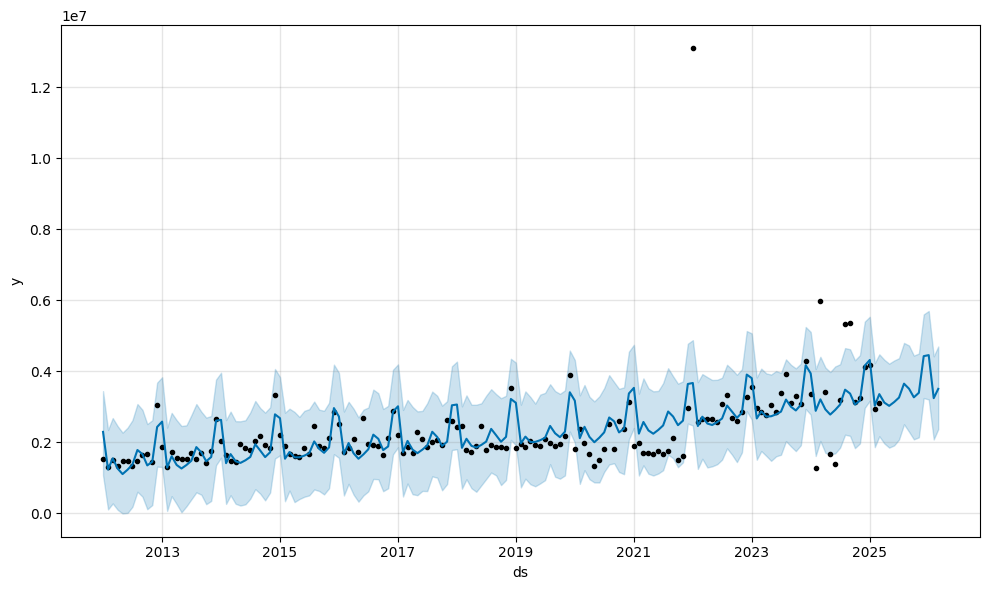

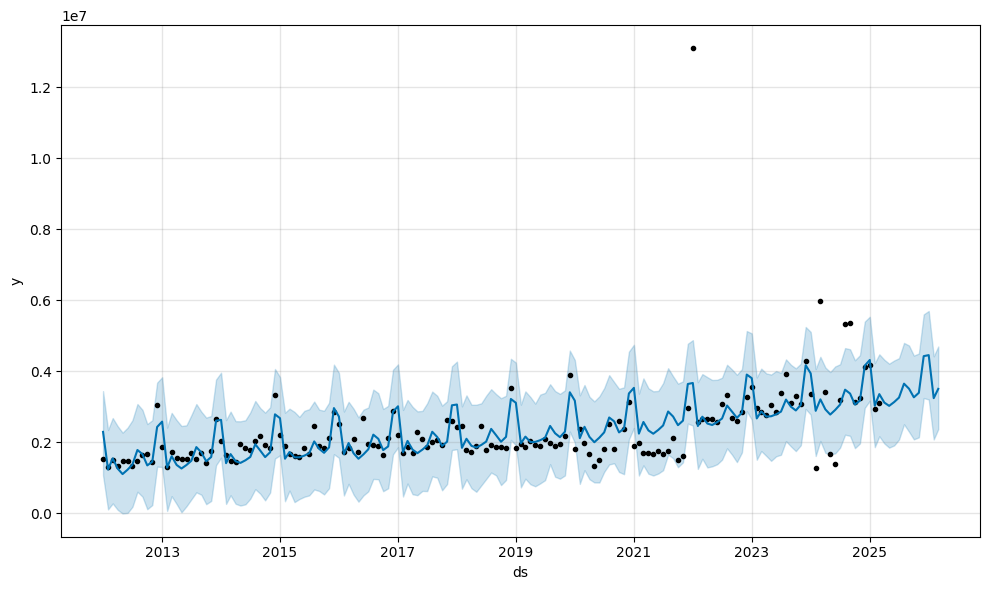

In [ ]:
model.plot(forecast)

In [ ]:
df_rev = pd.read_csv(r'/content/drive/MyDrive/Dashboard_data/final_data/df_rev.csv', sep=';')
df_rev

,Data,vinculo,origem,tipo,nome_rubrica,valor_arrecadado
0,2004-01-01,400,Contribuições,Outras Contribuições Previdenciárias,Outras Contribuições Sociais,37.56
1,2004-01-01,6050,Contribuições Intra-Orçamentárias,Contr. Patronal - Servidor Civil Ativo - Princ...,Contr. Patronal - Servidor Ativo - Plano em Ca...,179881.44
2,2004-01-01,400,Outras Receitas Correntes,Outras Receitas Não Arrec.e Não Projetadas p/ ...,Outras Receitas - Diversas - Adm. Indireta,4699.39
3,2004-01-01,400,Contribuições Intra-Orçamentárias,Contr. Patronal - Servidor Civil Ativo - Princ...,Contr. Patronal - Servidor Ativo - Plano em Re...,2665961.14
4,2004-01-01,400,Contribuições,Contr.do Servidor Civil Ativo - Principal,Contr.do Servidor Civil Ativo - Plano em Repar...,2917709.38
...,...,...,...,...,...,...
13113,2025-03-01,6050,Contribuições Intra-Orçamentárias,Contr. Patronal - Servidor Civil Ativo - Princ...,Contr.Patronal Supl. - Serv. Ativo - Plano em ...,3.71
13114,2025-03-01,6049,Contribuições Intra-Orçamentárias,Contr. Patronal - Servidor Civil Ativo - Princ...,Contr. Patronal - Servidor Ativo - Plano em Re...,34921.77
13115,2025-03-01,6050,Contribuições,Contr.do Servidor Civil - Pensionistas - Princ...,Contr.do Servidor Civil - Pensionistas - Plano...,796.46
13116,2025-03-01,6049,Contribuições Intra-Orçamentárias,Contr. Patronal - Servidor Civil Ativo - Princ...,Contr. Patronal - Servidor Ativo - Plano em Re...,103926.64


In [ ]:
# Generating a dataframe with paid expenses data from 2024 onwards

# Define the folder path
exp_folder_2024_onwards = pathlib.Path(r'/content/drive/MyDrive/Dashboard_data/Despesas/2024+')

# Read all CSV files efficiently
df_list = [
    pd.read_csv(expense_file).dropna(axis=1, how='all')
    for expense_file in exp_folder_2024_onwards.glob("*.csv")
]

# Concatenate all DataFrames
df_exp_2024_onwards = pd.concat(df_list, ignore_index=True)

# Convert financial columns efficiently
cols_to_convert = ['valorliquidado', 'restospagarnaoprocessadosliquidados']
df_exp_2024_onwards[cols_to_convert] = df_exp_2024_onwards[cols_to_convert].apply(
    lambda col: pd.to_numeric(col.str.replace('R\$ ', '', regex=True).str.replace(',', '.'), errors='coerce')
)

# Filter out rows with zero values in all columns to convert
df_exp_2024_onwards = df_exp_2024_onwards[
    df_exp_2024_onwards[cols_to_convert].ne(0).any(axis=1)
]

# Rename and clean up columns
df_exp_2024_onwards.rename(columns={
    'exercicio': 'YEAR', 'mes': 'MONTH'
}, inplace=True)

# Fix month values
df_exp_2024_onwards['MONTH'] = df_exp_2024_onwards['MONTH'].replace({0: 1, 13: 12}).astype(int)

# Convert date
df_exp_2024_onwards['Data'] = pd.to_datetime(df_exp_2024_onwards[['YEAR', 'MONTH']].assign(DAY=1))

# Sorting once before processing
df_exp_2024_onwards.sort_values('Data', inplace=True, ignore_index=True)

# Subtract the last nonzero appearance for target column
cols = ['subacao', 'naturezadespesa', 'fonterecursos', 'YEAR']
target_col = 'restospagarnaoprocessadosliquidados'
df_exp_2024_onwards[target_col + '_prev'] = (
    df_exp_2024_onwards.where(df_exp_2024_onwards[target_col] != 0).groupby(cols)[target_col].shift(1).fillna(0)
)
df_exp_2024_onwards[target_col] -= df_exp_2024_onwards[target_col + '_prev']


# df_exp_2024_onwards.loc[df_exp_2024_onwards['subacao'] == 4396, 'subacao'] = 2870
# df_exp_2024_onwards.loc[df_exp_2024_onwards['subacao'] == 4471, 'subacao'] = 2872
# df_exp_2024_onwards.loc[df_exp_2024_onwards['subacao'] == 4413, 'subacao'] = 2873

In [ ]:
df_exp_2024_onwards = df_exp_2024_onwards[['Data', 'unidadeorcamentaria', 'subacao', 'naturezadespesa', 'valorliquidado', 'restospagarnaoprocessadosliquidados']]

In [ ]:
len(df_exp_2024_onwards)

2213

In [ ]:
df_exp_2024_onwards.columns

Index(['Data', 'unidadeorcamentaria', 'subacao', 'naturezadespesa',
       'valorliquidado', 'restospagarnaoprocessadosliquidados'],
      dtype='object')

In [ ]:
df_exp_2024_onwards['naturezadespesa'].unique()

array([339037, 339039, 339047, 339040, 319192, 319007, 319013, 339030,
       339033, 339035, 339086, 319011, 319016, 319092, 319094, 339036,
       339046, 339048, 339049, 339092, 319113, 332039, 339014, 339093,
       449040, 449052, 319001, 319003, 319091, 999999, 339091, 339147])

In [ ]:
df_exp_2024_onwards

,Data,unidadeorcamentaria,subacao,naturezadespesa,valorliquidado,restospagarnaoprocessadosliquidados
0,2024-01-01,7001,4396,319011,350329.90,0.0
1,2024-01-01,7002,2758,319003,8010.17,0.0
2,2024-01-01,7002,2758,319001,403383.48,0.0
3,2024-01-01,7002,2756,319092,8535.36,0.0
4,2024-01-01,7002,2756,319003,1258605.90,0.0
...,...,...,...,...,...,...
2208,2025-04-01,7001,2681,319113,111894.83,0.0
2209,2025-04-01,7001,2681,319113,34886.39,0.0
2210,2025-04-01,7003,9075,339047,0.00,0.0
2211,2025-04-01,7001,2529,339035,0.00,0.0


In [ ]:
df_exp_2024_onwards

,Data,unidadeorcamentaria,subacao,naturezadespesa,valorliquidado,restospagarnaoprocessadosliquidados
0,2024-01-01,7001,4396,319011,350329.90,0.00
1,2024-01-01,7002,2758,319003,8010.17,0.00
2,2024-01-01,7002,2758,319001,403383.48,0.00
3,2024-01-01,7002,2756,319092,8535.36,0.00
4,2024-01-01,7002,2756,319003,1258605.90,0.00
...,...,...,...,...,...,...
2208,2025-04-01,7001,2681,319113,111894.83,0.00
2209,2025-04-01,7001,2681,319113,34886.39,0.00
2210,2025-04-01,7003,9075,339047,0.00,3599.35
2211,2025-04-01,7001,2529,339035,0.00,14300.00


In [ ]:
arquivo = r'/content/drive/MyDrive/Previsoes_orcamento/despesas/ate_2023/Histórico de Despesas.xlsx'
df_7001 = pd.read_excel(arquivo,sheet_name='7001.t')
df_7002 = pd.read_excel(arquivo,sheet_name='7002.t')
df_7003 = pd.read_excel(arquivo,sheet_name='7003.t')

#adicionando Total nos df's originais, pois podemos fazer previsões só com ele
df_7001['Total'] = df_7001.iloc[:, 2:].sum(axis=1)
df_7002['Total'] = df_7002.iloc[:, 2:].sum(axis=1)
df_7003['Total'] = df_7003.iloc[:, 2:].sum(axis=1)

In [ ]:
df_7001

,Data,T,7001-1373-339039,7001-1373-449052,7001-1503-339030,7001-1503-339035,7001-1503-339039,7001-1503-449051,7001-1503-449052,7001-1504-339036,...,7001-9042-332001,7001-9071-319091,7001-9071-339047,7001-9071-339091,7001-9071-339092,7001-9071-339093,7001-9085-319091,7001-9085-339091,7001-9090-319113,Total
0,2011-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9808.44,28495.84,NaN,NaN,NaN,NaN,NaN,NaN,581973.30
1,2011-02-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2599.52,NaN,276953.25,NaN,NaN,NaN,NaN,NaN,NaN,914536.39
2,2011-03-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2599.52,3026.06,272912.56,NaN,NaN,NaN,NaN,NaN,NaN,981859.26
3,2011-04-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2599.52,NaN,321495.11,NaN,NaN,NaN,NaN,NaN,NaN,1055549.42
4,2011-05-01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2599.52,NaN,276319.59,NaN,NaN,62.43,NaN,NaN,NaN,1015353.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2023-08-01,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2132888.35,NaN,NaN,NaN,NaN,NaN,NaN,3648890.17
152,2023-09-01,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1540325.82,NaN,NaN,NaN,NaN,NaN,NaN,3219329.65
153,2023-10-01,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1534057.96,NaN,NaN,NaN,NaN,NaN,NaN,3138475.70
154,2023-11-01,155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1551838.22,NaN,NaN,NaN,NaN,NaN,NaN,3085073.74


In [ ]:
df_7001_m12

col,Comp.pagto.,7001-2529-332039-6069,7001-2529-339014-6069,7001-2529-339030-6069,7001-2529-339033-6069,7001-2529-339035-6069,7001-2529-339037-6069,7001-2529-339039-6069,7001-2529-339040-6069,7001-2529-339092-6069,...,7001-4396-339048-6069,7001-4396-339049-6069,7001-4413-339039-6069,7001-4471-339040-6069,7001-9071-339047-1,7001-9071-339047-6069,7001-9071-339091-6069,7001-9071-339093-6069,Total,T
0,2012-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2012-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2012-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,2012-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,2012-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-11,333.333333,1231.115833,608.617500,1693.072500,1609.375000,21162.914167,43501.887500,25495.640000,201.705000,...,0.0,1352.887500,130.793333,135312.641667,1.110697e+06,621778.165000,29.483333,0.0,3.471952e+06,155
155,2024-12,0.000000,1794.428333,513.235833,1700.093333,1191.666667,15077.137500,43519.100833,25546.604167,201.705000,...,0.0,1293.120000,147.460000,130359.791667,1.115172e+06,624023.639167,29.483333,0.0,3.457397e+06,156
156,2025-01,0.000000,1794.428333,513.235833,1686.595833,2383.333333,14187.973333,43090.937500,25778.051667,6.665833,...,0.0,1251.300833,72.398333,114299.071667,1.100846e+06,730704.135833,29.483333,0.0,3.525212e+06,157
157,2025-02,0.000000,1772.536667,458.562500,2998.013333,3575.000000,14134.938333,43498.087500,26802.967500,44.374167,...,0.0,1418.290833,36.336667,124754.234167,1.125811e+06,727144.979167,29.483333,0.0,3.664128e+06,158


In [ ]:
python -V

NameError: name 'python' is not defined